In [31]:
from pathlib import Path
from sklearn.feature_selection import SelectKBest, chi2
import openpyxl
import matplotlib.pyplot as plt
import polars as pl
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import TweetTokenizer
from wordcloud import WordCloud
import numpy as np

# HELPERS

In [32]:
def ruta_parquet(nombre_archivo: str) -> Path:
    ruta = f"data/{nombre_archivo}.parquet"
    rutafinal = Path().parent / ruta
    print(f"Ruta final: {rutafinal}")
    return rutafinal

def cargar_parquet(nombre_parquet: str) -> pl.LazyFrame:
    ruta = ruta_parquet(nombre_parquet) 
    return pl.read_parquet(ruta).lazy()

def guardar_parquet(data: pl.LazyFrame | pl.DataFrame, nombre_parquet: str) -> pl.LazyFrame:
    ruta = ruta_parquet(nombre_parquet)
    if isinstance(data, pl.LazyFrame):
        data.sink_parquet(ruta)
        return cargar_parquet(nombre_parquet)
    else:
        data.write_parquet(ruta)
        return cargar_parquet(nombre_parquet)

In [33]:
IMPRIMIR = True

def imprimir(mensaje: str, parametros=None, collect_lazy_frame=False, **kwargs):
    if not IMPRIMIR:
        return
    # Normaliza la fuente de valores: dict explícito o kwargs
    values = {}
    if isinstance(parametros, dict):
        values.update(parametros)
    values.update(kwargs)

    # Soporte opcional para LazyFrame
    if collect_lazy_frame:
        for k, v in list(values.items()):
            if hasattr(v, "collect"):
                values[k] = v.collect()

    print(mensaje.format(**values))

In [34]:

# DEFINICIONES INICIALES
ruta = Path().parent / "data/opiniones.xlsx"
print(f"Ruta del archivo Excel: {ruta} [exists: {ruta.exists()}]")

workbook = openpyxl.load_workbook(ruta, read_only=True)
hojas = workbook.sheetnames
hojas = [hoja.lower().replace(" ", "_") for hoja in hojas]
for hoja in hojas:
    print(f",{hoja}",end="", flush=True)

def obtener_nombre_hoja(sheet_index: int) -> str:
    """Obtiene el nombre de la hoja dado su índice."""
    nombre_hoja = hojas[sheet_index]
    return nombre_hoja


def calificaciones(calificacion:str) -> int:
    """Convierte la calificación de string a int."""
    calificacion_map = {
        "Pésimo": 1,
        "Malo": 2,
        "Regular": 3,
        "Muy bueno": 4,
        "Excelente": 5
    }
    return calificacion_map.get(calificacion, 0)


def tratar_columna(col:str) -> str:
    """Trata el nombre de una columna para que sea válido en polars."""
    col = col.strip().lower().replace(" ", "_").replace("-", "_")
    return col


def añadir_columna_lugar_turistico(iteracion: int) -> pl.LazyFrame:
    df_excel = pl.read_excel(ruta, sheet_id=iteracion+1).lazy()
    nombre_hoja = obtener_nombre_hoja(iteracion)
    
    df_excel = (
        df_excel
        .with_columns([
            pl.lit(nombre_hoja).alias("lugar_turistico"),
            pl.col("Calificación").map_elements(calificaciones).alias("calificacion_numerica"),
        ])
    )

    df_excel = df_excel.rename({col: tratar_columna(col) for col in df_excel.collect_schema().names()})
    return df_excel


def juntar_df(lista_df: list[pl.LazyFrame]) -> pl.LazyFrame:
    nuevo_df_excel = pl.concat(lista_df)
    return nuevo_df_excel




Ruta del archivo Excel: data/opiniones.xlsx [exists: True]
,basilica_colegiata_560,mercado_hidalgo_600,casa_de_diego_rivera_698,universidad_de_guanajuato_900,alhóndiga_930,teatro_juárez_1,010,jardín_de_la_unión_1,134,callejón_del_beso_1,360,monumento_pípila_1,620,museo_de_las_momias_1,650

# Limpiezsa y tratamiento del dataset

In [35]:
lista_df: list[pl.LazyFrame] = []
for i, hoja_n in enumerate(hojas):
    df = añadir_columna_lugar_turistico(i)
    df_p = guardar_parquet(df, hoja_n)
    lista_df.append(df)


# Unir todos los DataFrames en uno solo (NO SE USA PERO POR SI ACASO)
todos_los_df = juntar_df(lista_df)

imprimir(f"{todos_los_df.collect()['opinión'][:5]}")
print(f"Numero de opiniones: {todos_los_df.collect().height:,}")



separador = f" Columnas: {todos_los_df.collect().columns}"
imprimir(F"{"="*len(separador)}")
imprimir(separador)
imprimir(F"{"="*len(separador)}")


Ruta final: data/basilica_colegiata_560.parquet
Ruta final: data/basilica_colegiata_560.parquet


Ruta final: data/mercado_hidalgo_600.parquet
Ruta final: data/mercado_hidalgo_600.parquet
Ruta final: data/casa_de_diego_rivera_698.parquet
Ruta final: data/casa_de_diego_rivera_698.parquet
Ruta final: data/universidad_de_guanajuato_900.parquet
Ruta final: data/universidad_de_guanajuato_900.parquet
Ruta final: data/alhóndiga_930.parquet
Ruta final: data/alhóndiga_930.parquet
Ruta final: data/teatro_juárez_1,010.parquet
Ruta final: data/teatro_juárez_1,010.parquet
Ruta final: data/jardín_de_la_unión_1,134.parquet
Ruta final: data/jardín_de_la_unión_1,134.parquet
Ruta final: data/callejón_del_beso_1,360.parquet
Ruta final: data/callejón_del_beso_1,360.parquet
Ruta final: data/monumento_pípila_1,620.parquet
Ruta final: data/monumento_pípila_1,620.parquet
Ruta final: data/museo_de_las_momias_1,650.parquet
Ruta final: data/museo_de_las_momias_1,650.parquet
shape: (5,)
Series: 'opinión' [str]
[
	""Basílica muy bien conservada,…
	""The Basilica (Guanajuato does…
	""Edificio de la iglesia amar

# CONTRUCCION DEL VOCABULARIO, DISTRIBUCIÓN FRECUENCIAS

In [36]:
class Texto:
    def __init__(self, lazy_frame: pl.LazyFrame, TOP_PALABRAS:int | None = None):
        self.SOS = "<s>"
        self.EOS = "</s>"
        self.UNK = "<unk>"
        self.tokenizer = TweetTokenizer()
        self.lazy_frame = lazy_frame
        self.TOP_PALABRAS = TOP_PALABRAS

        # Guardamos estados
        self._freq_dist: list[tuple[str, int]] = []
        self._final_vocab: set[str] = set()
        self._corpus: list[list[str]] = []
        

    
    def _tokenizar(self, texto: str) -> list[str]:
        tokens = self.tokenizer.tokenize(texto.lower().strip())
        return tokens


    def _tokenizar_data(self) -> pl.LazyFrame:
        df_limpio = (
            self.lazy_frame
            .drop_nulls(subset=["opinión"])
            .with_columns(
                pl.col("opinión")
                .cast(pl.Utf8)
                .str.strip_chars()                                 # recorta espacios
                .str.replace_all(r'^[“”"\'«»\(\)\[\]\s]+', '')      # limpia INICIO
                .str.replace_all(r'[“”"\'«»\(\)\[\]\s]+$', '')      # limpia FINAL
                .alias("opinión_limpia")
            )
            .filter(pl.col("opinión_limpia").str.len_chars() > 0)


            .with_columns(
                pl.col("opinión_limpia")
                .map_elements(self._tokenizar, return_dtype=pl.List(pl.Utf8))
                .alias("opinión_tokenizada")
            )
            .filter(pl.col("opinión_tokenizada").list.len() > 0)
        )
        return df_limpio

    
    def _distribuir_frecuencias(self) -> pl.LazyFrame:
        lf_counts = (
            self._tokenizar_data()
            .select(pl.col("opinión_tokenizada"))
            .explode("opinión_tokenizada")
            .group_by("opinión_tokenizada")
            .len()
            .rename({
                "len": "frecuencia",
                "opinión_tokenizada": "token"
                })
            .sort("frecuencia", descending=True)
        )
        return lf_counts


    

    # ============== VOCABULARIO FINAL ==============
    def _vocabulario_final(self) -> pl.LazyFrame:
        vocab = (
            self._distribuir_frecuencias()
            .select("token")
        )
        return vocab


    
    
    def __build_corpus(self) -> pl.LazyFrame:
        vocab_set = self.vocabulario
        
        PREFIJO_SOS = pl.lit([self.SOS, self.SOS])
        SUFIJO_EOS = pl.lit([self.EOS])
        UNK_LIT = pl.lit(self.UNK)
        VOCAB_LIT = pl.lit(list(vocab_set))

        corpus = (
            self._tokenizar_data()
            .with_row_index("rid")
            .select("rid", "opinión_tokenizada")
            .explode("opinión_tokenizada")
            .with_columns(
                # Aplica el enmascaramiento
                pl.when(pl.col("opinión_tokenizada").is_in(VOCAB_LIT))
                .then(pl.col("opinión_tokenizada"))
                .otherwise(UNK_LIT)
                .alias("tok_mask")
            )
            # Aquí lo que hacemos es juntar todos los tokens (ya enmascarados) en UNA lista por opinión
            .group_by("rid")
            .agg(pl.col("tok_mask").alias("tokens"))
            .with_columns(
                pl.concat_list([PREFIJO_SOS, pl.col("tokens"), SUFIJO_EOS])
                .alias("opinión_trigram")
            )
            .select("opinión_trigram")
        )
        return corpus
    
    
    # ================ PROPIEDADES ==============

    @property
    def freq_dist(self) -> list[tuple[str, int]]:
        if not self._freq_dist:
            df = (
                self._distribuir_frecuencias()
                .limit(self.TOP_PALABRAS)  # Si es None, no limita
                .collect(engine="streaming")
                .rows()
            )
            self._freq_dist = df
            self.id_map = {token: idx for idx, (token, _) in enumerate(self._freq_dist)}
                     
        return self._freq_dist
    
    @property
    def vocabulario(self) -> dict:
        if not self._final_vocab:
            df = (
                self._vocabulario_final()
                .select("token")
                .collect(engine="streaming")
                .to_series()
                .to_list()
            )
            self._final_vocab = set(df)
        return self._final_vocab
    

    @property
    def corpus(self) -> list[list[str]]:
        
        if not self._corpus:
            self._corpus = (
                self.__build_corpus()
                .collect(engine="streaming")
                .get_column("opinión_trigram")
                .to_list()
            )
        return self._corpus
    
    



## Limpieza
Se esta utilizando una limpieza de codigo de manera aislada y preparada, primero insertando token de inicio y de cierre preparando para poder hacer uso del mismo data set
Lista de cosas:
- Token de inicio y fin de oración

In [37]:
textos_objs = []
for df in lista_df:
    texto = Texto(df, TOP_PALABRAS=10)
    textos_objs.append(texto)


In [38]:
for texto in textos_objs:
    print(f"{"="*10} CORPUS {"="*10}")
    corpus = texto.corpus
    print(f"Tamaño del corpus: {len(corpus):,} opiniones")
    for opinion in corpus[:3]:
        print(opinion)

========== CORPUS ==========
Tamaño del corpus: 560 opiniones
['<s>', '<s>', 'basílica', 'muy', 'bien', 'conservada', ',', 'punto', 'central', 'en', 'la', 'ciudad', ',', 'muy', 'linda', 'por', 'dentro', 'vale', 'la', 'pena', 'darse', 'una', 'vuelta', 'para', 'conocer', ',', 'alto', 'significado', 'religioso', 'y', 'arquitectónico', '.', '</s>']
['<s>', '<s>', 'the', 'basilica', '(', 'guanajuato', 'does', 'not', 'have', 'a', 'cathedral', ',', 'it', 'is', 'situated', 'in', 'the', 'nearby', 'city', 'of', 'leon', ')', 'is', 'truly', 'imposing', 'both', 'during', 'the', 'day', 'and', 'when', 'illuminated', 'at', 'night', '.', 'it', 'also', 'has', 'some', 'lovely', 'polychrome', 'sculpture', 'and', 'a', 'great', 'organ', '.', '</s>']
['<s>', '<s>', 'edificio', 'de', 'la', 'iglesia', 'amarilla', 'es', 'un', 'abigarrado', 'y', 'nahu', 'crear', 'una', 'más', 'bella', 'de', 'atocha', '.', 'he', 'venido', 'a', 'cabo', 'mejor', 'en', 'frente', 'de', 'la', 'misma', 'guanajuato', 'es', 'menor', 'cua

In [39]:

for texto in textos_objs:
    print(f"{"="*10} FREQ_DIST {"="*10}")
    freq_dist = texto.freq_dist
    print(f"Tamaño de la distribución de frecuencias: {len(freq_dist):,} tokens")
    print(freq_dist)
    

========== FREQ_DIST ==========
Tamaño de la distribución de frecuencias: 10 tokens
[('.', 1244), (',', 1035), ('de', 918), ('la', 751), ('the', 636), ('a', 470), ('y', 431), ('en', 415), ('es', 371), ('el', 323)]
========== FREQ_DIST ==========
Tamaño de la distribución de frecuencias: 10 tokens
[(',', 1542), ('.', 1523), ('de', 914), ('the', 619), ('a', 591), ('y', 567), ('la', 478), ('and', 409), ('que', 398), ('es', 388)]
========== FREQ_DIST ==========
Tamaño de la distribución de frecuencias: 10 tokens
[('.', 1979), (',', 1280), ('de', 1135), ('the', 1029), ('of', 732), ('la', 705), ('a', 695), ('and', 571), ('diego', 501), ('y', 495)]
========== FREQ_DIST ==========
Tamaño de la distribución de frecuencias: 10 tokens
[('.', 1727), ('de', 1539), (',', 1486), ('la', 1301), ('y', 741), ('que', 684), ('es', 663), ('a', 605), ('the', 555), ('en', 520)]
========== FREQ_DIST ==========
Tamaño de la distribución de frecuencias: 10 tokens
[('.', 2177), (',', 1928), ('de', 1924), ('la', 1

In [40]:
for texto in textos_objs:
    print(f"{"="*10} VOCABULARIO {"="*10}")
    vocabulario = texto.vocabulario
    print(f"Tamaño del vocabulario: {len(vocabulario):,}")
    # Imprimir solo los primeros 20 elementos del vocabulario (es un set)
    print(list(vocabulario)[:10])

========== VOCABULARIO ==========
Tamaño del vocabulario: 3,939
['cubo', 'benedict', 'muestra', 'céntrica', 'aprovechamos', 'bustling', 'perfecta', 'child', 'facilmente', 'da']
========== VOCABULARIO ==========
Tamaño del vocabulario: 4,399
['fácilmente', 'emplear', 'candy', 'offering', 'autoridades', 'wide', 'muestra', 'expectations', 'diciembre', 'querras']
========== VOCABULARIO ==========
Tamaño del vocabulario: 4,535
['offering', 'habitaciòn', 'id', 'wide', 'hitler', 'muestra', 'expectations', 'minimal', 'facil', 'recreando']
========== VOCABULARIO ==========
Tamaño del vocabulario: 4,481
['id', 'wide', 'muestra', 'facil', 'cómodo', 'céntrica', 'profesional', 'brilliant', 'mediados', 'da']
========== VOCABULARIO ==========
Tamaño del vocabulario: 5,776
['facil', 'child', 'ganar', 'da', 'natural', 'balcón', 'organizadas', 'timeline', 'condiciones', 'abundan']
========== VOCABULARIO ==========
Tamaño del vocabulario: 5,420
['graced', 'da', 'conforma', 'condiciones', 'vedeno', 'navid

# FEATURE SELECTION POR CHI CUADRADO

In [41]:

class VectorPalabra:
    def __init__(self, textos: list[Texto], lugares: list[str] = [], top_k: int = 50, con_stopwords: bool = False):
        self.textos: list[Texto] = textos
        self.lugares: list[str] = lugares
        self.top_k: int = top_k
        self.vectorizer = None
        self.idx_to_word = None
        self.bow = None
        self.labels = None
        self.con_stopwords = con_stopwords
    
    

    def _flatten(self):
        """
        Solo aplana: construye ejemplos (strings) y etiquetas (lugares).
        No vectoriza aquí.
        """
        ejemplos, etiquetas = [], []
        for texto_obj, lugar in zip(self.textos, self.lugares):
            for opinion in texto_obj.corpus:
                ejemplos.append(" ".join(opinion))
                etiquetas.append(lugar)
        return ejemplos, etiquetas


    def bow_builder(self, ejemplos=None):
        """
        Construye el BoW usando los ejemplos ya aplanados.
        Deja todo exactamente donde lo tenías: vectorizer, bow, idx_to_word.
        """
        # Si no existe el flag, no lo rompas: por defecto False para respetar tu lógica.
        if not hasattr(self, "con_stopwords"):
            self.con_stopwords = False

        if not self.con_stopwords:
            self.vectorizer = CountVectorizer(stop_words=['spanish', 'english'])
        else:
            self.vectorizer = CountVectorizer()
            
        if ejemplos is None:
            ejemplos, etiquetas = self._flatten()
            self.labels = etiquetas
        
        self.bow = self.vectorizer.fit_transform(ejemplos)
        vocab = self.vectorizer.vocabulary_
        self.idx_to_word = {idx: w for w, idx in vocab.items()}
        return self.bow


    def _build_dataset(self):
        """
        Mantiene tu flujo original: si ya hay bow, regresa; si no,
        aplana y luego llama a bolt(ejemplos). Finalmente setea labels.
        """
        if self.bow is not None:
            if self.labels is not None:
                _,etiquetas = self._flatten()
                self.labels = etiquetas
            return
        
        ejemplos, etiquetas = self._flatten()
        self.bow_builder(ejemplos)          # usa la función separada para construir el BoW
        self.labels = etiquetas


    def k_best(self, target_lugar: str):
        """ 
        Selecciona las k mejores características (palabras) 
        para el lugar objetivo usando Chi-cuadrado.
        """
        self._build_dataset()
        y_labels = [1 if lbl == target_lugar else 0 for lbl in self.labels] # type: ignore
        
        k = min(self.top_k, self.bow.shape[1]) # type: ignore

        selector = SelectKBest(score_func=chi2, k=k)
        selector.fit(self.bow, y_labels) # type: ignore
        return selector


    def word_cloud_for(self, target_lugar: str):
        """
        Genera y muestra una word cloud para las k mejores palabras
        asociadas al lugar objetivo.
        """
        selector = self.k_best(target_lugar)
        indices = selector.get_support(indices=True)

        chi2_scores = selector.scores_
        best_scores = np.nan_to_num(chi2_scores[indices], nan=0.0) # type: ignore

        palabras = [self.idx_to_word[i] for i in indices] # type: ignore
        pares = sorted(zip(palabras, best_scores), key=lambda t: t[1], reverse=True)[:self.top_k]
        pares = [(w, s) for (w, s) in pares if w not in {"<s>", "</s>", "<unk>"}]
        pesos = dict(pares)

        print(f"Chi cuadrado para: top-[{self.top_k}] para [{target_lugar}]: {pesos}")
        wordcloud = WordCloud(width=800, height=400, background_color='black').generate_from_frequencies(pesos)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.show()


    





# USO DE VectorPalabra

In [42]:
textos_objs = textos_objs
lugares = hojas
word_vectorizer = VectorPalabra(textos=textos_objs, lugares=lugares, top_k=50)

In [43]:
bow = word_vectorizer.bow_builder()
print("BoW construido.")
print("BoW shape:", bow.shape)

BoW construido.
BoW shape: (10462, 22634)


Generando word cloud para: basilica_colegiata_560
Chi cuadrado para: top-[50] para [basilica_colegiata_560]: {'iglesia': 1500.456446663699, 'basilica': 1385.2825256261362, 'basílica': 1161.339867949008, 'church': 979.5151763472505, 'amarillo': 423.19124244123014, 'virgen': 410.9780044615806, 'iglesias': 336.339043047031, 'paz': 329.98508200401034, 'misa': 318.2785714285713, 'mass': 262.880503661154, 'templo': 254.03502323965333, 'altar': 241.30273620253993, 'virgin': 229.86785714285716, 'churches': 206.90117654502208, 'color': 189.56891789942725, 'ubicada': 176.881285513375, 'hermosa': 175.80741523175186, 'catedral': 170.63728396706088, 'interior': 163.00613535304595, 'patrona': 159.13928571428565, 'beautiful': 156.6432374293109, 'barroco': 153.1958399457541, 'señora': 144.15199961858352, 'ii': 141.45714285714286, 'organ': 141.45714285714286, 'chandeliers': 141.43101256600397, 'yellow': 141.43101256600397, 'inside': 127.15004095171821, 'bonita': 125.96009226908296, 'religioso': 123.968

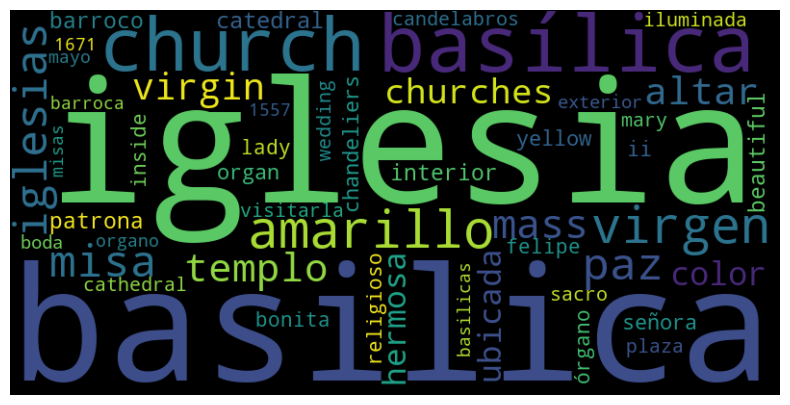

Generando word cloud para: mercado_hidalgo_600
Chi cuadrado para: top-[50] para [mercado_hidalgo_600]: {'mercado': 4157.563425075816, 'market': 2465.9864596747616, 'comida': 1254.6997625189042, 'food': 1211.6450568155003, 'stalls': 639.896637610131, 'carnitas': 573.7832659347647, 'mercados': 557.3604862848044, 'artesanías': 529.7687323195012, 'dulces': 526.3588380085431, 'comprar': 524.198016235997, 'meat': 476.66333333333336, 'frutas': 475.26002708342867, 'eiffel': 442.83477443262484, 'precios': 432.2794960252047, 'fresh': 410.7165439806924, 'markets': 410.28691041752523, 'souvenirs': 406.2608574816486, 'comer': 371.6532767074517, 'recuerdos': 370.99744475615347, 'items': 370.2858689096524, 'buy': 323.1922492919293, 'vegetables': 312.2966666666667, 'artesanias': 302.37563058299776, 'alimentos': 299.98670801275284, 'crafts': 299.2430807710508, 'fruits': 295.85999999999996, 'verduras': 295.85999999999996, 'variedad': 287.324965748103, 'comidas': 286.5506539379235, 'tortas': 263.80440711

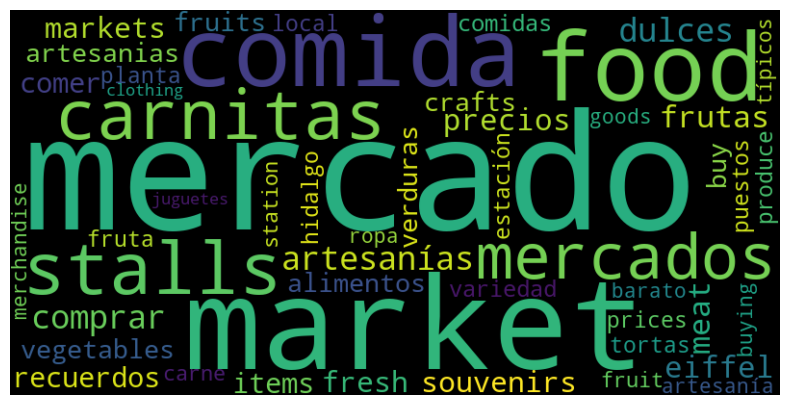

Generando word cloud para: casa_de_diego_rivera_698
Chi cuadrado para: top-[50] para [casa_de_diego_rivera_698]: {'diego': 6740.914776993071, 'rivera': 6657.412395098288, 'his': 3785.914573120022, 'casa': 2339.906997455584, 'obras': 1704.5541098319775, 'work': 1687.9050797932023, 'art': 1512.8525606562187, 'home': 1320.8565703648205, 'house': 1211.9685624017452, 'frida': 1142.702674556096, 'works': 1047.1740415488694, 'artists': 734.4103185303984, 'pintor': 695.8572860360146, 'artista': 659.4745809434144, 'museum': 615.057926500004, 'nació': 613.8448330008916, 'born': 558.6600266622916, 'paintings': 535.8923561168423, 'sketches': 529.9659705584751, 'pinturas': 525.4136036332621, 'muebles': 517.3751338440599, 'artist': 509.6774312162449, 'of': 493.8515302492325, 'artistas': 468.17556225994446, 'kahlo': 459.327936299083, 'was': 448.06915879304387, 'childhood': 432.13136658820116, 'he': 410.5260344013385, 'lived': 405.13747013080825, 'collection': 394.93079516197275, 'floors': 377.1421890

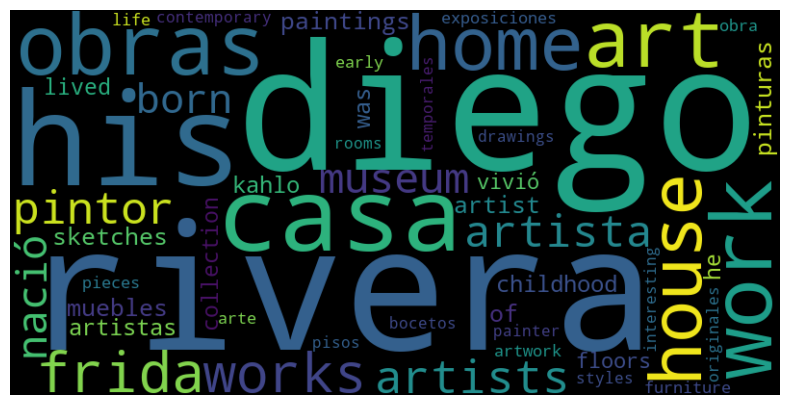

Generando word cloud para: universidad_de_guanajuato_900
Chi cuadrado para: top-[50] para [universidad_de_guanajuato_900]: {'universidad': 2737.233985766235, 'edificio': 959.6781422181335, 'escaleras': 558.7567769977434, 'university': 512.3701447617938, 'escalinatas': 503.71214831042136, 'escalinata': 492.3253517895034, 'arquitectura': 480.42588585560014, 'escalera': 264.43711585209974, 'escalones': 257.80268005773036, 'the': 221.92631545324687, 'estudiar': 179.0381397484974, 'and': 149.23288887611233, 'campus': 148.74222222222224, 'universidades': 148.74222222222224, 'construcción': 140.16732005264947, 'estudios': 138.14236215233058, 'of': 128.22660124418147, 'building': 122.44151775139265, 'stairs': 121.83499069124964, 'blanco': 119.57926111031607, 'cantera': 117.62992251963936, 'aulas': 116.8688888888889, 'su': 107.90848061391921, 'to': 106.68353955906994, 'construccion': 105.87832073385724, 'reto': 105.30432502885651, 'ug': 105.30432502885651, 'steps': 103.02934347335427, 'conocerl

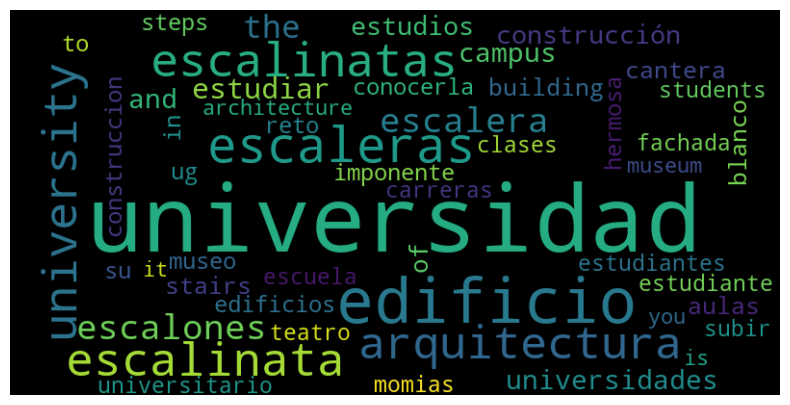

Generando word cloud para: alhóndiga_930
Chi cuadrado para: top-[50] para [alhóndiga_930]: {'independencia': 1641.1071573705035, 'historia': 1233.0166184585785, 'history': 871.2038971399865, 'méxico': 758.0909157123855, 'independence': 729.8344740524773, 'murales': 640.259989858827, 'alhóndiga': 578.5351478278109, 'salas': 406.4550504436204, 'revolution': 366.93852393551794, 'alhondiga': 328.3732243222615, 'murals': 293.778129743585, 'mexican': 293.754895464586, 'nuestra': 288.8699639007924, 'museo': 268.1659187170215, 'war': 259.0281821504473, 'pre': 253.93959754788858, 'granaditas': 219.49853198507347, 'morado': 213.77553700171285, 'artifacts': 199.0732514455945, 'hidalgo': 192.29275505176983, 'mexico': 191.03653199431943, 'domingos': 184.81541179102095, 'building': 184.1478712178494, 'guerra': 181.3069358365388, 'lucha': 167.8661487249997, 'hechos': 160.6041559831404, 'héroes': 159.80726270284214, 'chavez': 153.74193548387098, 'granos': 153.74193548387098, 'granary': 143.04863592471

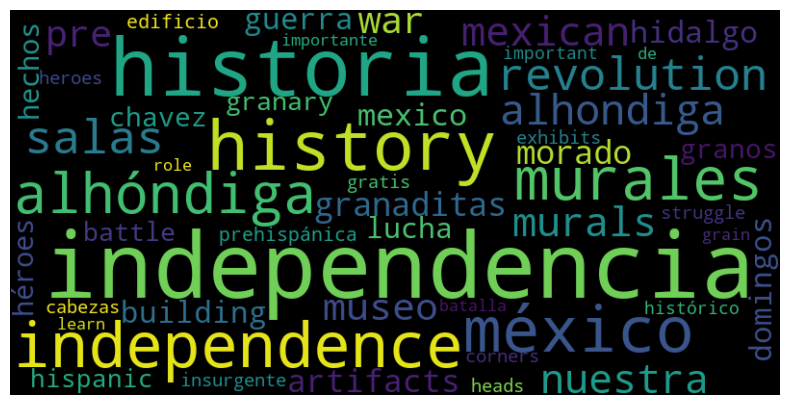

Generando word cloud para: teatro_juárez_1,010
Chi cuadrado para: top-[50] para [teatro_juárez_1,010]: {'teatro': 2270.3940260099703, 'theater': 907.785658606487, 'theatre': 494.2879358092308, 'interior': 382.216700156143, 'porfirio': 276.59597814228664, 'hermoso': 263.3042710746953, 'performance': 258.9894288565202, '35': 258.8579038568891, 'arquitectura': 250.53276277760148, '1903': 240.84751475232162, 'porfiriato': 231.28902325900754, 'fuera': 215.84910167458102, 'artes': 206.02484778561748, 'teatros': 204.84239190039932, 'díaz': 194.85239972623353, 'acústica': 177.809900990099, 'musas': 176.35586630121813, 'decoración': 172.80722666003373, 'joya': 160.49538651055772, 'dentro': 159.02168592691228, 'evento': 150.51826775144718, 'concert': 143.66326633509738, 'eventos': 139.30566618602475, 'inaugurado': 129.73440125302204, 'espectáculos': 124.72082211495311, 'columnas': 122.39485091849976, 'cervantino': 119.9570809216343, 'inside': 117.95784318939086, 'festival': 117.80038017343843, '

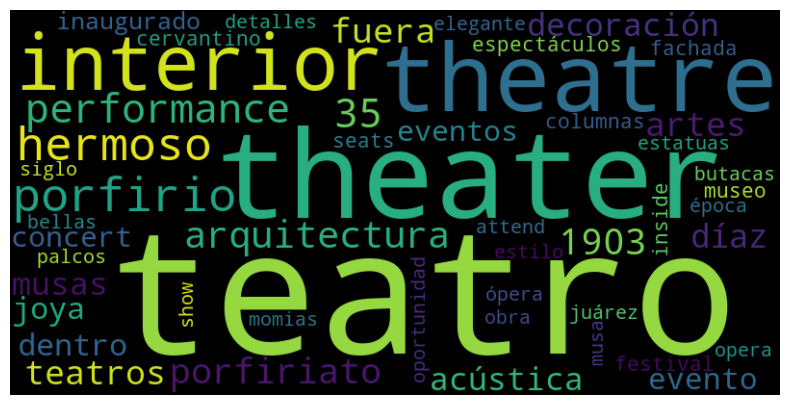

Generando word cloud para: jardín_de_la_unión_1,134
Chi cuadrado para: top-[50] para [jardín_de_la_unión_1,134]: {'restaurantes': 2036.315154809329, 'restaurants': 1646.2574381806562, 'jardin': 1309.2656344522354, 'jardín': 1172.225441755382, 'music': 887.1408973279908, 'mariachi': 821.2095631398953, 'mariachis': 773.9098555003393, 'trees': 736.7577717654326, 'plaza': 615.6678662847743, 'bares': 607.9818627891812, 'música': 565.1720328783315, 'benches': 488.95597159415763, 'garden': 486.39657668470556, 'watch': 468.4498666276992, 'square': 443.594648376111, 'people': 438.6192110319135, 'juarez': 433.3694672847248, 'watching': 390.26994317407986, 'surrounded': 390.05262446443544, 'bands': 382.36732118720084, 'árboles': 382.36732118720084, 'ambiente': 379.77886474631293, 'sit': 356.33100884964097, 'rodeado': 352.1745837957825, 'park': 350.8285235723273, 'cafes': 344.0574502684279, 'union': 333.80155856588186, 'gazebo': 304.3527336860669, 'musica': 284.172597281222, 'musicians': 263.12267

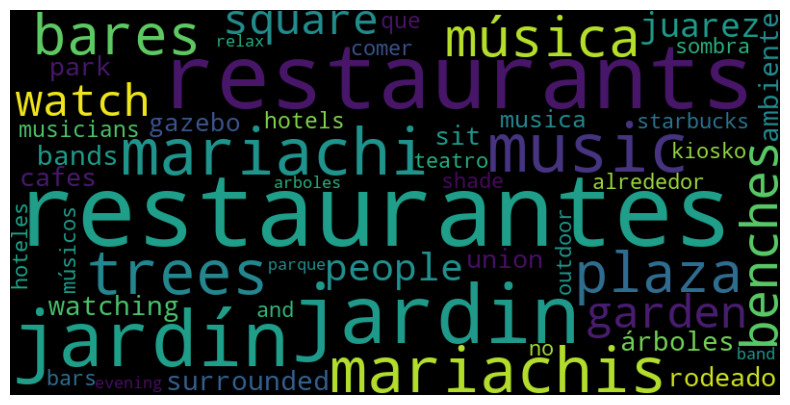

Generando word cloud para: callejón_del_beso_1,360
Chi cuadrado para: top-[50] para [callejón_del_beso_1,360]: {'callejón': 3457.835774030209, 'beso': 3076.5716472616436, 'leyenda': 1920.9226066982096, 'pareja': 1472.2639986231652, 'foto': 1023.7306555146616, 'kiss': 970.0451266681536, 'alley': 926.6111930545826, 'amor': 821.5378742435986, 'balcón': 757.9741991328727, 'escalón': 740.9620718902012, 'tercer': 516.9738346706514, 'romántico': 441.4302493553453, 'tu': 424.8154300737586, 'balcones': 408.9651610228798, 'legend': 373.5831524049359, 'romeo': 368.0955882352941, 'callejoneada': 365.8599726515679, 'story': 360.9527509066784, 'parejas': 329.0715432223398, 'callejon': 328.85087466895214, 'te': 320.7061440302937, 'enamorados': 314.5544117647059, 'suerte': 298.021203253879, 'tradición': 263.2505246341473, 'the': 258.1513770334625, 'estrecho': 244.5010121070808, 'balconies': 235.56684269455965, 'romantic': 226.4551490999608, 'romántica': 222.4698767759088, 'cuentan': 220.87995306768684

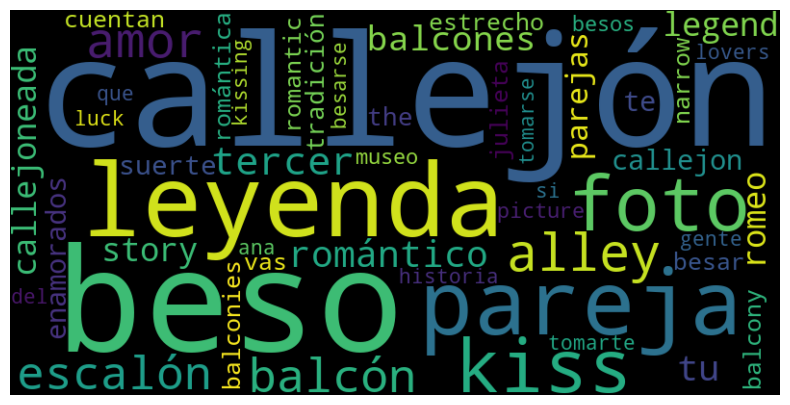

Generando word cloud para: monumento_pípila_1,620
Chi cuadrado para: top-[50] para [monumento_pípila_1,620]: {'vista': 3003.0204936482583, 'funicular': 2274.129223908187, 'monumento': 2268.410368405272, 'pípila': 1388.5006599233736, 'view': 1314.002351164225, 'monument': 1159.5180780282658, 'ciudad': 1116.0582267760053, 'mirador': 969.3154100373511, 'subir': 957.8586488216253, 'up': 713.0290810782086, 'desde': 697.8146092587662, 'teleférico': 640.9857989611825, 'panorámica': 528.5969612629325, 'views': 512.2857896779558, 'statue': 466.71153811354884, 'top': 461.6478549558565, 'city': 428.70134968993307, 'pipila': 400.5253619778091, 'la': 385.9568429138685, 'down': 369.57400463449426, 'estatua': 353.57335061925966, 'toda': 303.8159573425031, 'bajar': 265.1907428384464, 'arriba': 255.04634753539642, 'the': 245.73037111109468, 'caminando': 234.3881625639103, 'atardecer': 218.2741114993838, 'llegar': 207.36103370169013, 'vistas': 204.64831807059343, 'ride': 200.57949199267517, 'guanajuato'

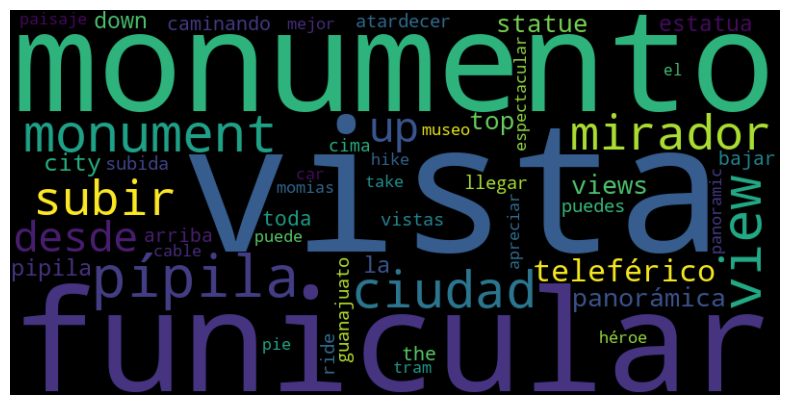

Generando word cloud para: museo_de_las_momias_1,650
Chi cuadrado para: top-[50] para [museo_de_las_momias_1,650]: {'momias': 4221.124062743199, 'mummies': 1977.4451455592691, 'museo': 1916.2351093082636, 'cuerpos': 1222.6264729925415, 'bodies': 854.4969696969697, 'museum': 810.9266773739542, 'no': 741.4456448976412, 'las': 552.1016626000967, 'momia': 551.7018395892143, 'dead': 526.5252113555363, 'mummy': 496.694476262397, 'que': 474.86454909799727, 'interesante': 385.1223331291999, 'cadáveres': 384.5236363636364, 'these': 347.776301110903, 'they': 341.3268298071709, 'death': 336.7666544008269, 'momificados': 336.45818181818186, 'mummified': 315.0957575757576, 'not': 311.8858262259564, 'preserved': 294.06768911863924, 'natural': 279.81720794363224, 'creepy': 279.58039143857525, 'proceso': 274.2492187748701, 'muerte': 258.79381374313954, 'recorrido': 255.34283221493482, 'guía': 253.2774704581331, 'pero': 251.10641672864617, 'cemetery': 245.66787878787883, 'children': 213.29227270730527,

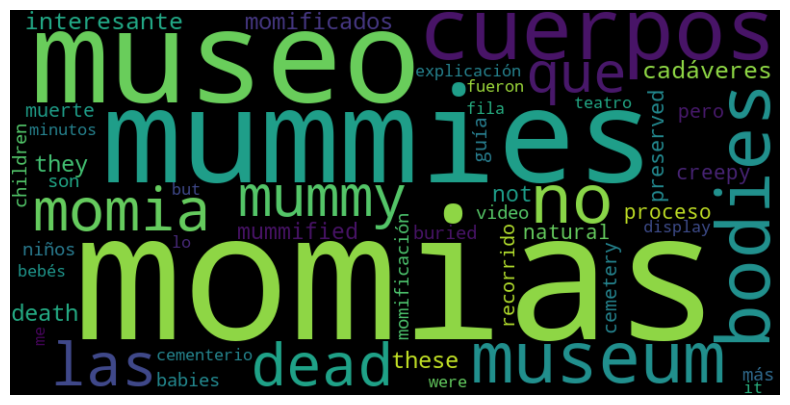

In [44]:

for lugar in lugares:
    print(f"Generando word cloud para: {lugar}")
    word_vectorizer.word_cloud_for(lugar)
